# Fun with GYRE for a 3 $M_{\odot}$ star

# Imports and whatnot

In [158]:
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f9fc8b02590>

In [19]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec

import astropy.units as u

from ipywidgets import interact, IntSlider

import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [70]:
from importlib import reload
import sys
sys.path.append("../")

import mesagrid
reload(mesagrid)

<module 'mesagrid' from '/home/tom/Documents/research/kavli-2023/algol-seismology/notebooks/../mesagrid.py'>

In [247]:
usecols_history = ['model_number', 'star_age', 'log_Teff', 'log_L',
                   'center_h1', 'center_he4']
cpus = 8

track = mesagrid.Track("../template",
                       usecols_history=usecols_history,
                       cpus=cpus)

## MESA Plots

In [335]:
def simple_hr(track, label='', ylabel=r'Luminosity $\mathbf{L/L_{\odot}}$',
              cbar_var="center_he4", cbar_label=r"$X_{\rm He, center}$",
              fig=None, ax=None, show=True, **kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    
    df = track.history
    df = df.loc[df.center_h1 <= df.center_h1.max() - 0.005]
    if 's' not in kwargs:
        kwargs['s'] = 10
    if 'cmap' not in kwargs:
        kwargs['cmap'] = "copper"
    ax.plot(df['log_Teff'], df['log_L'], color="lightgrey", zorder=-1)
    ax.scatter(df['log_Teff'], df['log_L'], c=df[cbar_var], **kwargs)
    
    if label != '':
        ax.annotate(label, xy=(0.97, 0.97), xycoords="axes fraction",
                    weight='bold', size=0.8 * fs,
                    ha='right', va='top')
    ax.invert_xaxis()
    ax.set_xlabel(r'Effective temperature $\mathbf{T_{eff}/K}$')
    ax.set_ylabel(ylabel)
    
    inset_ax = ax.inset_axes([0.38, 0.025, 0.6, 0.025])
    fig.colorbar(ax.collections[0], label=cbar_label, cax=inset_ax, orientation="horizontal", location="top")
    
    # plt.tight_layout()
    
    if show:
        plt.show()
        
    return fig, ax

## GYRE Plots

In [329]:
def period_spacing_plot(track, profile_number, x_var="period", label_modes=False,
                        fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(8, 3))

    df = track.freqs[profile_number - 1]
    df = df[(df["l"] == 1) & (df["m"] == 0) & (df["n_p"] == 0)]
    periods = 1 / df["Re(freq)"].values * u.day
    ng = df["n_g"].values
    delta_p  = periods[:-1] - periods[1:]
    
    x_vals = periods if x_var == "period" else -ng
    
    if label_modes:
        ax.plot(x_vals[:-1], delta_p)
    else:
        ax.plot(x_vals[:-1], delta_p, marker="o")
        
    if label_modes:
        for i in range(len(delta_p)):
            ax.annotate(ng[i], xy=(x_vals[i], delta_p[i]), ha="center", va="center",
                        fontsize=0.25*fs, color="grey", bbox=dict(boxstyle="circle", facecolor="white", ec="tab:blue"))

    ax.set_xlabel(r"Period, $P \, [\rm days]$" if x_var == "period" else r"$k$ (g-modes)")
    ax.set_ylabel(r"$\Delta P \, [\rm days]$")
    
    ax.annotate("$l = 1, m = 0$ g modes", xy=(0.98, 0.02), xycoords="axes fraction", ha="right", va="bottom")
    
    if show:
        plt.show()

    return fig, ax, ng, periods

In [372]:
def plot_propagation_diagram(track, model_num,
                             lw=1, brunt_col=plt.get_cmap("plasma")(0.3), lamb_col=plt.get_cmap("plasma")(0.9),
                             x_scale="linear", fractional_mass=False, fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 3))

    m = track.profiles[model_num - 1]["mass"]
    if fractional_mass:
        m = m / m.max()
        
    brunt = track.profiles[model_num - 1]["brunt_N"] * ((2 * np.pi * u.Hz).to(u.day**(-1))).value
    lamb = track.profiles[model_num - 1]["lamb_S"] * ((2 * np.pi * u.Hz).to(u.day**(-1))).value
        
    ax.plot(m, brunt, lw=lw, color=brunt_col, label="Brunt–Väisälä", zorder=4)
    ax.plot(m, lamb, lw=lw, color=lamb_col, label="Lamb", zorder=3)
    
    ax.set_yscale("log")
    ax.set_xscale(x_scale)
    ax.set_ylim(bottom=1e0)
    
    ax.fill_between(m, ax.get_ylim()[0], brunt, color=brunt_col, alpha=0.2, zorder=4)
    ax.fill_between(m, lamb, ax.get_ylim()[-1], color=lamb_col, alpha=0.2, zorder=3)

    ax.set_ylabel(r"Cycles per day")
    ax.set_xlabel(r"Mass $\mathbf{M/M_{\odot}}$")
    ax.legend(loc="best", ncol=2, fontsize=0.4*fs)
    
    if show:
        plt.show()
        
    return fig, ax
    
def plot_composition_profile(track, model_num,
                             lw=2, H_col=plt.get_cmap("cividis")(0.3), He_col=plt.get_cmap("cividis")(0.9),
                             fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 3))             

    ax.plot(track.profiles[model_num - 1]["mass"], track.profiles[model_num - 1]["x_mass_fraction_H"],
            lw=lw, color=H_col, label="Hydrogen")
    ax.plot(track.profiles[model_num - 1]["mass"], track.profiles[model_num - 1]["y_mass_fraction_He"],
            lw=lw, color=He_col, label="Helium")
    ax.set_ylim(0, 1)

    for el in ["center_h1", "center_he4"]:
        ax.axhline(track.history.iloc[0][el], color="grey", linestyle="--", lw=0.5, zorder=-1)

    ax.set_xlabel(r"Mass $\mathbf{M/M_{\odot}}$")
    ax.legend(loc="lower right", ncol=2, fontsize=0.4*fs)
    
    if show:
        plt.show()
        
    return fig, ax

In [363]:
def compare_track(track, model_num, label='', ylabel=r'Luminosity $\mathbf{L/L_{\odot}}$',
                  cbar_var="center_h1", cbar_label=r"$X_{\rm H, center}$",
                  show=True, label_modes=False, **kwargs):
    
    # setup subplots
    fig = plt.figure(layout="constrained", figsize=(18, 9))
    gs = GridSpec(3, 3, figure=fig)
    ax_text = fig.add_subplot(gs[0, 0])
    ax_hr = fig.add_subplot(gs[1:, 0])
    ax_comp = fig.add_subplot(gs[0, 1])
    ax_prop = fig.add_subplot(gs[1, 1])
    ax_deltap = fig.add_subplot(gs[2, 1])
    
    ax_text.annotate(r"$3 \, {\rm M_{\odot}}$ " + "star\nSingle star evolution", xy=(0.5, 0.5),
                     xycoords="axes fraction", ha="center", va="center", fontsize=1.35*fs)
    ax_text.annotate(f'Star Age: {track.history.loc[model_num - 1]["star_age"] / 1e6:1.1f}Myr, ' \
                     + r"$X_{\rm H, center}=$" + f'{track.history.loc[model_num - 1]["center_h1"]:1.3f}',
                     xy=(0.5, 0.1), xycoords="axes fraction", ha="center", va="center", fontsize=0.8*fs)
    ax_text.axis("off")

    # create HRD
    fig, ax_hr = simple_hr(track, label=label, ylabel=ylabel, cbar_var=cbar_var, cbar_label=cbar_label,
                           show=False, fig=fig, ax=ax_hr, **kwargs)
    
    # some settings
    lw = 3
    H_col = plt.get_cmap("cividis")(0.3)
    He_col = plt.get_cmap("cividis")(0.9)
        
    # add marker on HRD
    lTeff, lL = track.history.loc[model_num - 1]["log_Teff"], track.history.loc[model_num - 1]["log_L"]
    ax_hr.scatter(lTeff, lL, s=50, facecolors="none", color="red")
    
    # create composition plot            
    plot_composition_profile(track, model_num, fig=fig, ax=ax_comp, show=False)
    
    plot_propagation_diagram(track, model_num, fig=fig, ax=ax_prop, show=False)
    
    # create period spacing plot
    period_spacing_plot(track=track, profile_number=model_num, label_modes=label_modes,
                        fig=fig, ax=ax_deltap, show=False)
    ax_deltap.set_ylim(-0.1, 0.15)
    
    if show:
        plt.show()
        
    return fig, ax

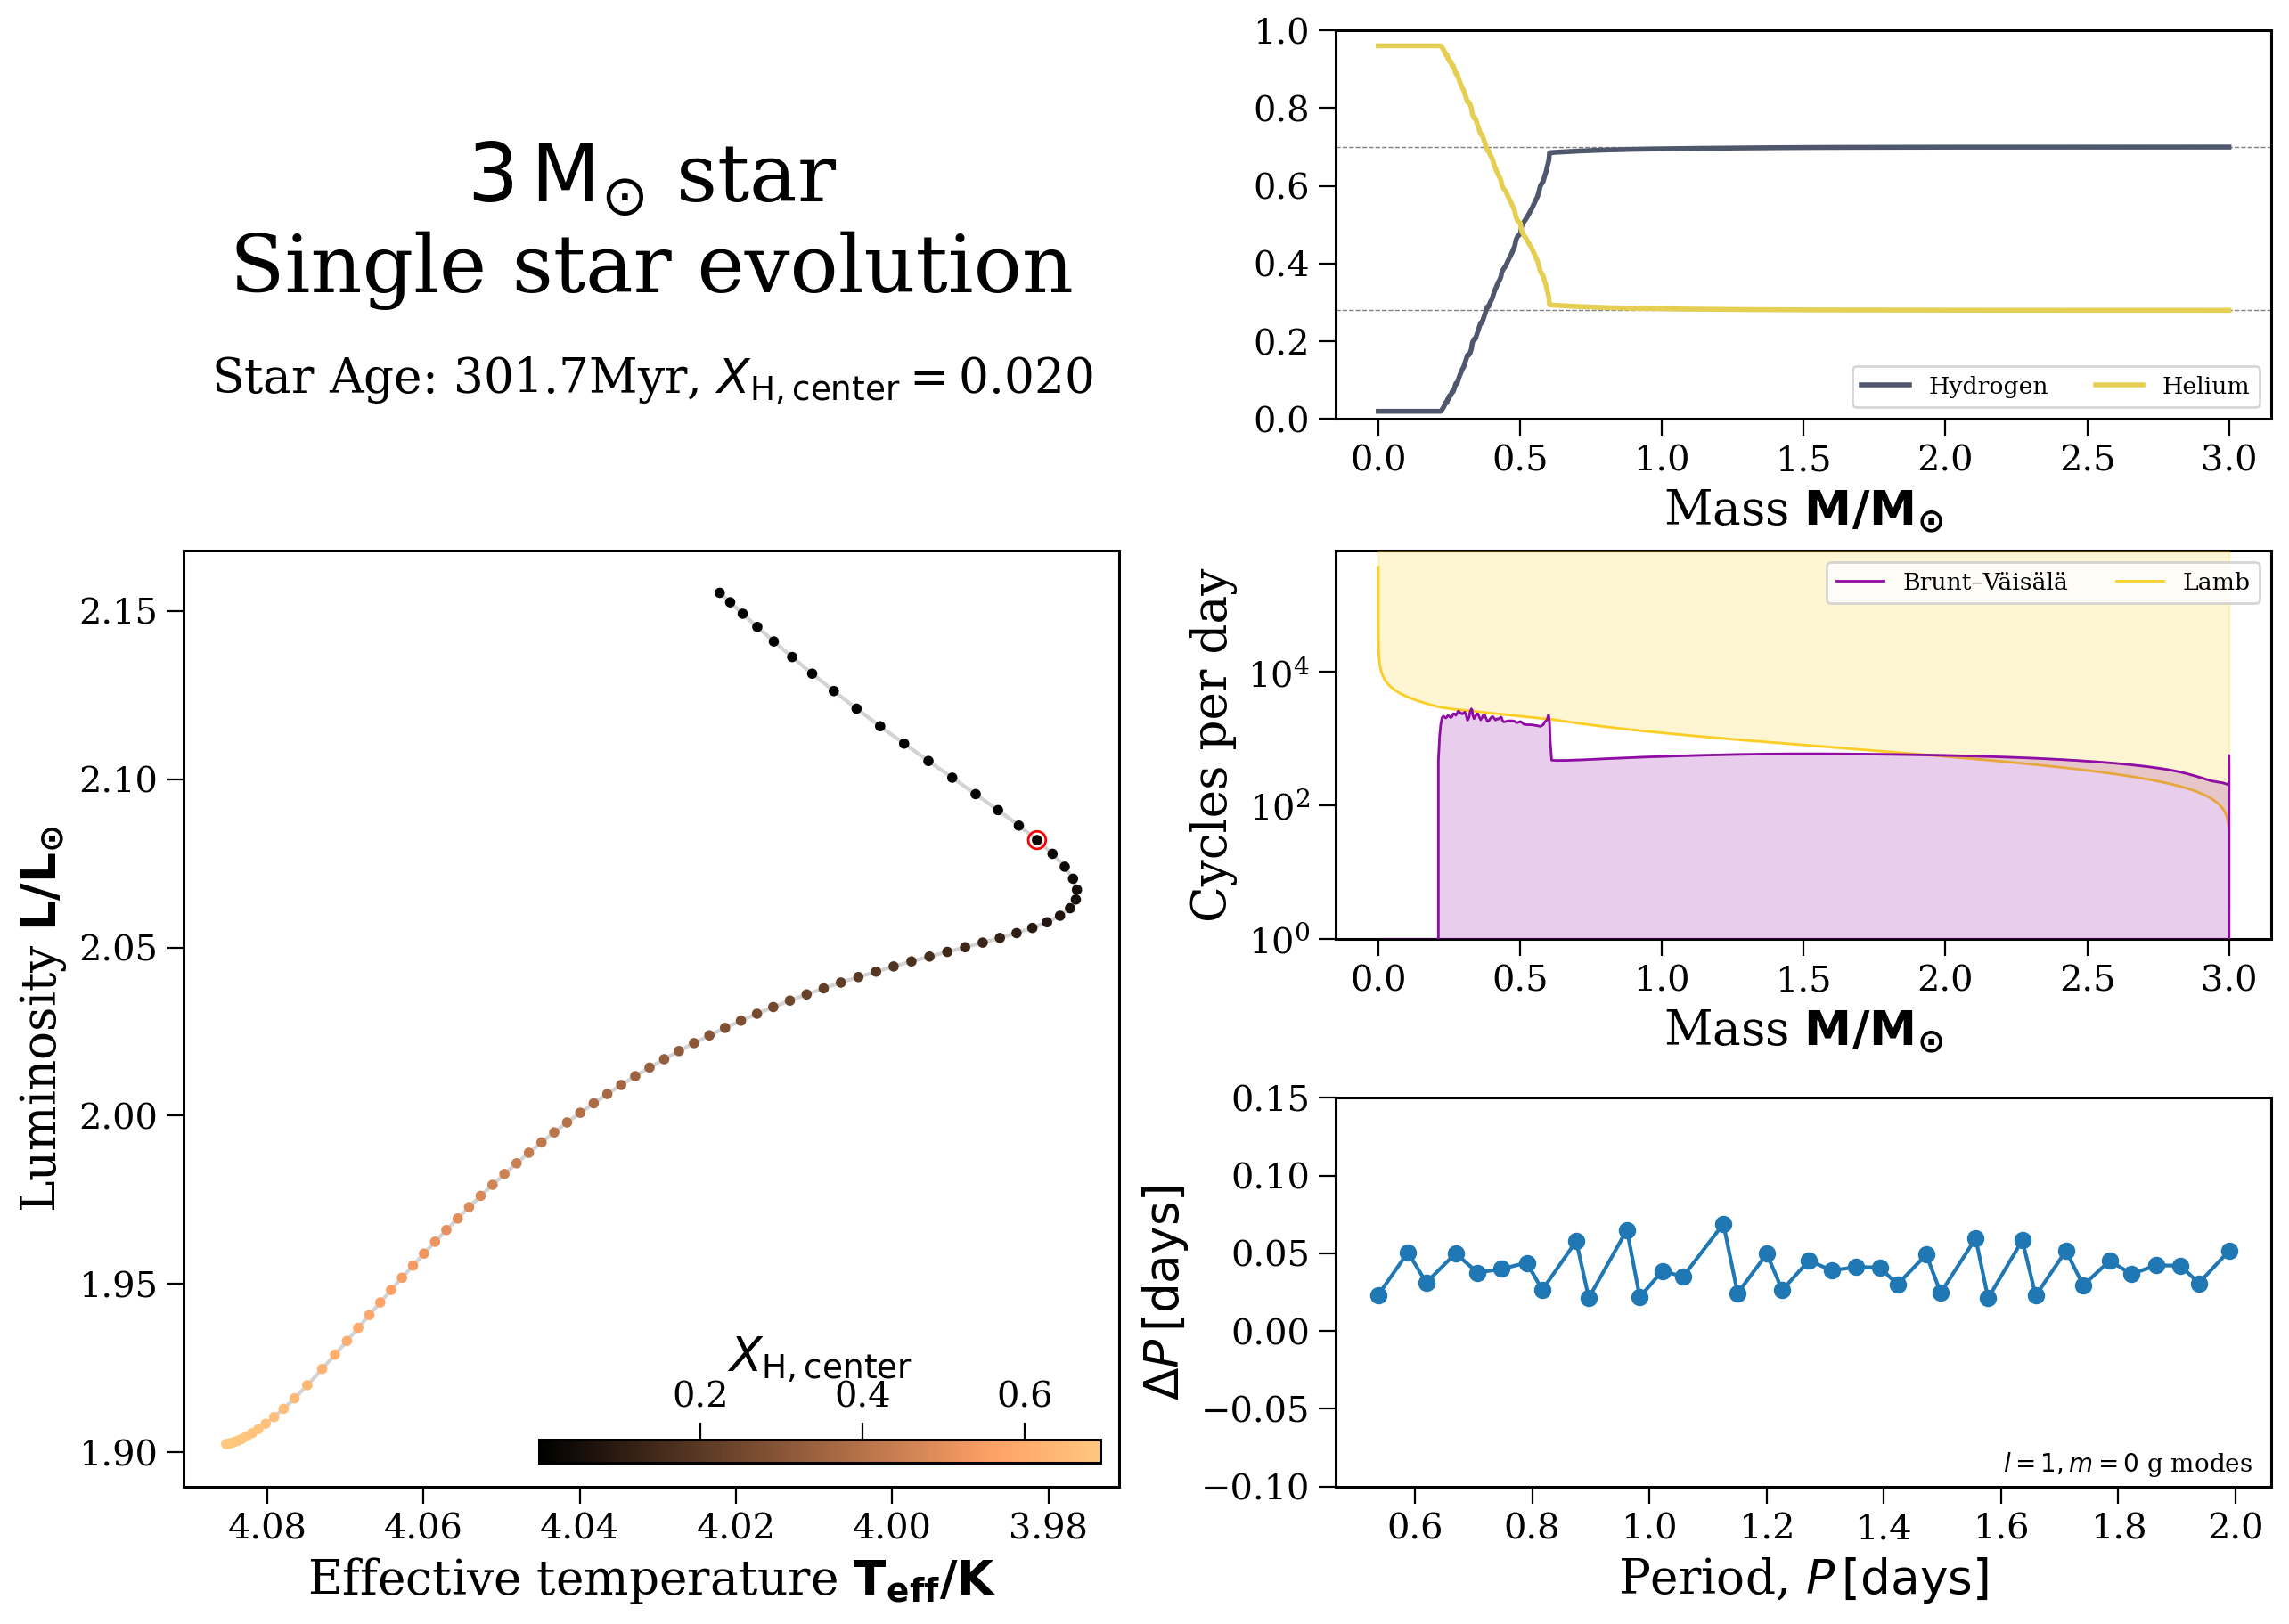

(<Figure size 1800x900 with 5 Axes>,
 <Axes: xlabel='Mass $\\mathbf{M/M_{\\odot}}$', ylabel='Cycles per day'>)

In [375]:
compare_track(track, 100)

In [332]:
def interact_all(model_number):
    compare_track(track, model_num=model_number)

In [333]:
model_min, model_max = track.history.loc[track.history.center_h1 <= track.history.center_h1.max()-0.005]["model_number"].min(), track.history["model_number"].max()

In [377]:
interact(interact_all,
         model_number=IntSlider(value=40, min=model_min, max=model_max, continuous_update=False));

interactive(children=(IntSlider(value=40, continuous_update=False, description='model_number', max=116, min=27…